## IMPORTS



To improve readability and organization, I've placed all necessary installations and imports at the beginning of the notebook, making the code easier to follow.

In [ ]:
!pip install keras-tuner

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras import initializers

from tensorflow.keras.layers import (
    Input, Embedding, GRU, Dense, Dropout,
    Concatenate, BatchNormalization, Activation
)
import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

# INTRODUCTION

Before diving into the model architecture and preprocessing, we begin with a brief **data inspection** to better understand the structure and characteristics of the dataset.  
This includes checking column names, data types, missing values, and unique values per feature. This step is essential to guide preprocessing choices and avoid common pitfalls.

The dataset used in this notebook is hosted on a **public GitHub repository** and will be downloaded directly using `curl` to ensure reproducibility.


In [ ]:
!curl -o input_data.pkl https://raw.githubusercontent.com/theoradicella/deep-learning/main/input_data.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3310k  100 3310k    0     0  9784k      0 --:--:-- --:--:-- --:--:-- 9766k


In [ ]:
data = pd.read_pickle("input_data.pkl")

data.head()

,Hotel_Address,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Hotel_number_reviews,Reviewer_number_reviews,Review_Score,Review,Review_Type
88526,Scarsdale Scarsdale Place Kensington Kensingto...,5/2/2017,8.1,Copthorne Tara Hotel London Kensington,United Kingdom,7105,2,6.7,Expensive room rate that didn t include parki...,Bad_review
42019,53 53 59 Kilburn High Road Maida Vale London C...,8/4/2016,7.1,BEST WESTERN Maitrise Hotel Maida Vale,United Kingdom,1877,8,5.8,Bedroom in the basement No windows Very small...,Bad_review
80574,Pelai Pelai 28 Ciutat Vella 08002 Barcelona Spain,11/17/2016,8.6,Catalonia Ramblas 4 Sup,United Kingdom,4276,2,6.3,Room ready for a makeover Location,Bad_review
27131,3 3 Place du G n ral Koenig 17th arr 75017 Par...,2/4/2016,7.1,Hyatt Regency Paris Etoile,United Kingdom,3973,3,5.8,Firstly the lady at the check in desk was qui...,Bad_review
63857,Epping Epping Forest 30 Oak Hill London IG8 9N...,7/27/2016,7.5,Best Western PLUS Epping Forest,United Kingdom,587,7,3.3,Not being able to park my vehicle due to the ...,Bad_review


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13772 entries, 88526 to 61379
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Hotel_Address            13772 non-null  object 
 1   Review_Date              13772 non-null  object 
 2   Average_Score            13772 non-null  float64
 3   Hotel_Name               13772 non-null  object 
 4   Reviewer_Nationality     13772 non-null  object 
 5   Hotel_number_reviews     13772 non-null  int64  
 6   Reviewer_number_reviews  13772 non-null  int64  
 7   Review_Score             13772 non-null  float64
 8   Review                   13772 non-null  object 
 9   Review_Type              13772 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 1.7+ MB


In [ ]:
data.nunique() # see amount of unique values for each column

,0
Hotel_Address,1367
Review_Date,730
Average_Score,33
Hotel_Name,1366
Reviewer_Nationality,148
Hotel_number_reviews,1085
Reviewer_number_reviews,94
Review_Score,34
Review,13076
Review_Type,2


Although this was initially overlooked in the written exam, we start by **double-checking** whether including `Review_Score` as an input feature might introduce **data leakage**. Since `Review_Score` and `Review_Type` are conceptually and statistically linked (e.g., a higher score likely means a good review), we'll compute their **correlation** and visualize their distributions before proceeding with preprocessing.

This step will ensure that our model remains fair and doesn’t inadvertently learn the labels from a directly correlated feature.


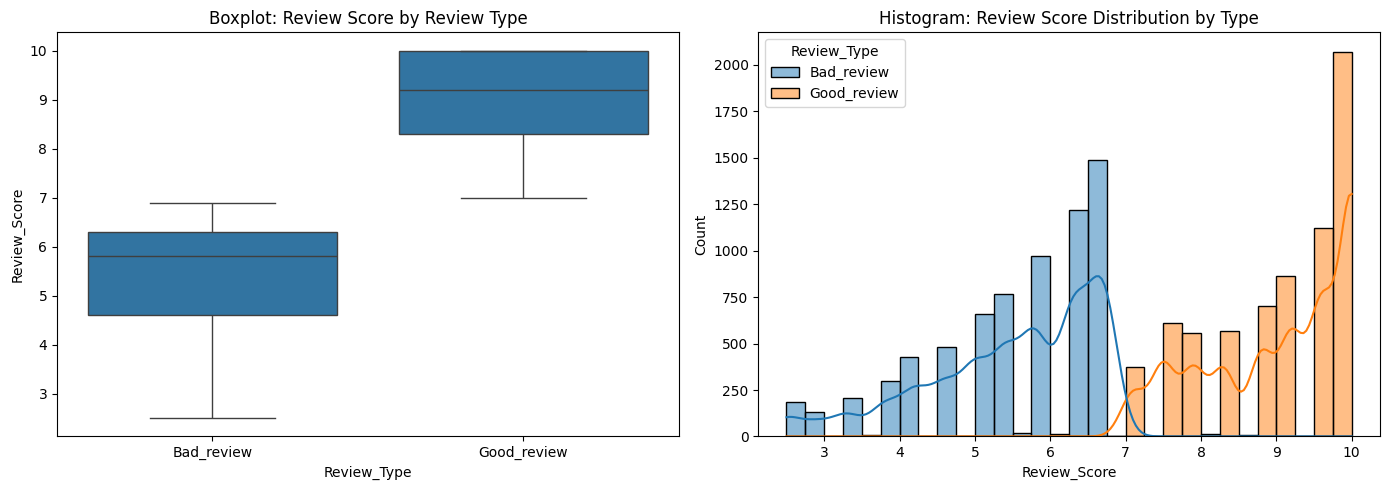

In [ ]:
# Create a 1-row, 2-column subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot: Review Score by Review Type
sns.boxplot(x="Review_Type", y="Review_Score", data=data, ax=axes[0])
axes[0].set_title("Boxplot: Review Score by Review Type")

# Histogram: Review Score Distribution
sns.histplot(data=data, x="Review_Score", hue="Review_Type", bins=30, kde=True, ax=axes[1])
axes[1].set_title("Histogram: Review Score Distribution by Type")

# Improve layout
plt.tight_layout()
plt.show()

In [ ]:
# Binarize the labels
data["Review_Type"] = data["Review_Type"].map({"Good_review": 1, "Bad_review": 0})

# Check correlation
correlation = data["Review_Score"].corr(data["Review_Type"])
print("Correlation between Review Score and Review Type:", correlation)

Correlation between Review Score and Review Type: 0.8622800389522722


## **CHANGE**
I analyzed the relationship between `Review_Score` and `Review_Type` using a boxplot, a histogram, and by computing their correlation. The correlation was very high (0.86), and the visualizations showed that reviews with a score above 7 were consistently labeled as “good.” This suggests that `Review_Type` is directly based on `Review_Score`. To avoid label leakage and reduce the input dimensionality by one, I will exclude `Review_Score` from the model inputs.


# 2A - PREPROCESSING


In this section, we prepare the dataset for training by implementing the preprocessing pipeline described in the written exam.  
The steps are as follows:

- We drop the `Review_Score` column due to its high correlation with the label, and we also drop the `Average_Score` column since it was **not mentioned** in the exam assignment and is not required for our task.

- The label `Review_Type` was already binarized (0 = Bad, 1 = Good) during correlation analysis. Here, we separate it from the input features as well as the `Review` text for future split and transformation.

- We **one-hot encode** categorical features such as `Hotel_Name`, `Hotel_Address`, and `Reviewer_Nationality`.

- The `Review_Date` is decomposed into three new features: **day**, **month**, and **year**, each of which is later scaled using **MinMax normalization**.

- We perform a **train-test split**, using 80% of the data for training and 20% for testing. The split is stratified by `Review_Type` to preserve the label distribution in both sets. This split is done before fitting any transformers, to prevent data leakage during preprocessing.

- Numeric features like `Hotel_number_reviews` and `Reviewer_number_reviews` are also scaled using **MinMax scaling** to bring them into a consistent range.

- The `Review` text is tokenized into integer sequences using a vocabulary-based tokenizer, and each sequence is padded to a fixed length of 400 tokens. This padding is used here to illustrate the expected input shape and preprocessing flow, but the final sequence length will be tuned later during hyperparameter optimization. We will not vectorize the text at this stage — instead, it will be passed into an Embedding layer in the model, as described in the written exam.

In [ ]:
X = data.drop(columns=["Review_Score", "Average_Score", "Review_Type"])

# Separate the target label (already binarized earlier for correlation analysis)
y = data["Review_Type"]

# Separate the text for proper split and transformation
X_text_raw = X["Review"].values

# Drop the original Review column from structured input
X.drop(columns=["Review"], inplace=True)

In [ ]:
# One-hot encode Hotel_Name, Hotel_Address, Reviewer_Nationality
X = pd.get_dummies(X, columns=["Hotel_Name", "Hotel_Address", "Reviewer_Nationality"], drop_first=True)

In [ ]:
# Convert Review_Date and extract year, month, day
X["Review_Date"] = pd.to_datetime(X["Review_Date"], errors='coerce')
X["Review_Year"] = X["Review_Date"].dt.year
X["Review_Month"] = X["Review_Date"].dt.month
X["Review_Day"] = X["Review_Date"].dt.day

# Drop the original Review_Date column
X.drop(columns=["Review_Date"], inplace=True)

In [ ]:
# ── Train/Test split (stratified, 20% test) ───────────────────
(X_text_train, X_text_test,
 X_features_train, X_features_test,
 y_train, y_test) = train_test_split(
    X_text_raw,
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print(f"Train size : {len(y_train)}")
print(f"Test  size : {len(y_test)}")

Train size : 11017
Test  size : 2755


In [ ]:
# MinMax scaling for date components
date_scaler = MinMaxScaler()

# Fit-transform the training dataset
X_features_train[["Review_Year", "Review_Month", "Review_Day"]] = date_scaler.fit_transform(
    X_features_train[["Review_Year", "Review_Month", "Review_Day"]]
)
# Transform the test dataset
X_features_test[["Review_Year", "Review_Month", "Review_Day"]] = date_scaler.transform(
    X_features_test[["Review_Year", "Review_Month", "Review_Day"]]
)

# MinMax scale Hotel_Review_Count and Reviewer_Review_Count
numeric_scaler = MinMaxScaler()

# Fit-transform the training dataset
X_features_train[["Hotel_number_reviews", "Reviewer_number_reviews"]] = numeric_scaler.fit_transform(
    X_features_train[["Hotel_number_reviews", "Reviewer_number_reviews"]]
)

# Transform the test dataset
X_features_test[["Hotel_number_reviews", "Reviewer_number_reviews"]] = numeric_scaler.transform(
    X_features_test[["Hotel_number_reviews", "Reviewer_number_reviews"]]
)

In [ ]:
# Tokenize Review text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_text_train)

vocab_size = len(tokenizer.word_index) + 1 # +1 for the padding token
print("Vocabulary size:", vocab_size)

# I will need to prepare the text multiple times later, thus I defined this helper function
def prepare_text_input(texts, tokenizer, sequence_length):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=sequence_length, padding='post', truncating='post')

X_text_padded = prepare_text_input(X_text_train, tokenizer, 400)

Vocabulary size: 10779


# 2B - INPUT SHAPES

At this stage, the review text is represented as a sequence of integers of shape `(sequence_length,)`. The transformation into dense vectors of shape `(sequence_length, embedding_dim)` will occur within the model via an Embedding layer, as planned in the written exam.

In [ ]:
# Check the shape of one instance from each input branch
print("Shape of one tokenized text input:", X_text_padded[0].shape)

# Later, after the embedding layer we will get shape (sequence_length, embedding_dimension)
embedding_dim = 64
embedded_sample = Embedding(vocab_size, embedding_dim)(X_text_padded[0]) # <- Just to show the shape

print("Shape of one embedded text input:", embedded_sample.shape)

Shape of one tokenized text input: (400,)
Shape of one embedded text input: (400, 64)


## **CORRECTION**

In the written exam, the structured input was said to consist of 9 fields. However, this overlooked the fact that one-hot encoding of categorical features increases dimensionality, and a few necessary adjustments further affected the final input shape:

- The feature `Review_Score` was removed to prevent label leakage, which reduced the input dimensionality by one.
- Additionally, the categorical features `Hotel_Name`, `Hotel_Address`, and `Reviewer_Nationality` were one-hot encoded. This significantly increased the number of structured input features, as each unique category value creates a separate binary column.

As a result, the final structured input vector has a shape of `(N,)`, where `N` is greater than 9 and depends on the cardinality of the encoded categorical features, in this case `2883`.


In [ ]:
print("Shape of one structured input (feature vector):", X.iloc[0].shape)

Shape of one structured input (feature vector): (2883,)


# 3,4,5 - OUTPUT, LOSS, MODEL CONFIGURATION

 I chose to use `Keras Tuner` - [documentation](https://keras.io/keras_tuner/) - because it integrates smoothly with Keras and allows for clean separation of concerns by encapsulating model construction and hyperparameter definitions within a dedicated `HyperModel` class - [documentation](https://keras.io/keras_tuner/api/hypermodels/). This keeps the code organized and modular while enabling automated hyperparameter search.

 The cell below defines `build_model`, the function that Keras Tuner will call every trial to construct and compile a fresh model instance with a specific set of sampled hyperparameters.

 This function also specifies which hyperparameters to tune, defines the full neural network architecture—including input branches, dropout, batch normalization, output layer, activations, etc.— as well as the loss function and optimizer, all according to the written exam instructions.

 To comply with the exam requirement that the notebook must run within a few minutes, I intentionally restricted the hyperparameter search space to a minimal set of values. This ensures faster tuning while still demonstrating the full model workflow.

In [ ]:
def build_model(hp, *, vocab_size, features_dimension):
    # ── Build Tunable Hyperparameters
    learning_rate     = hp.Choice("learning_rate", [1e-3])
    embedding_dim     = hp.Choice("embedding_dim", [64, 128])
    sequence_length   = hp.Choice("sequence_length", [250])

    num_rnn_layers    = hp.Choice("num_rnn_layers", [1])
    rnn_units         = hp.Choice("rnn_units", [64])

    num_dense_layers  = hp.Choice("num_dense_layers", [1, 2])
    dense_units       = hp.Choice("dense_units", [64])

    dropout_rate      = hp.Choice("dropout", [0.1])
    l2_strength       = hp.Choice("l2", [0.007])
    hp.Choice("epochs", [6])
    hp.Choice("batch_size", [32])

    # ── Text branch ──────────────────────────────────────────
    input_text = Input(shape=(sequence_length,), name="text_input")
    x_text     = Embedding(vocab_size, embedding_dim)(input_text)

    for i in range(num_rnn_layers):
        x_text = GRU(
            rnn_units,
            return_sequences=(i < num_rnn_layers - 1) # Only return sequences if not the last GRU layer
        )(x_text)

    # ── Features Branch ──────────────────────────────────────
    input_features = Input(shape=(features_dimension,), name="features_input")
    x_features     = Dense(64, kernel_initializer=initializers.HeUniform(), kernel_regularizer=regularizers.l2(l2_strength))(input_features)
    x_features     = BatchNormalization()(x_features)
    x_features     = Activation("relu")(x_features)
    x_features     = Dropout(dropout_rate)(x_features)

    # ── Concatenation of inputs ──────────────────────────────
    x = Concatenate()([x_text, x_features])

    # ── Dense block with BN -> ReLU -> Dropout ───────────────
    for _ in range(num_dense_layers):
        x = Dense(dense_units, kernel_initializer=initializers.HeUniform(), kernel_regularizer=regularizers.l2(l2_strength))(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Dropout(dropout_rate)(x)

    # ── Output layer + sigmoid activation ────────────────────
    output_layer = Dense(1, activation="sigmoid")(x)

    model = Model([input_text, input_features], output_layer)
    # ── BCE as Loss + Adam optimizer  ────────────────────────
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# 6 - MODEL EVALUATION

In this section, we perform hyperparameter tuning of our RNN model using Keras Tuner with a custom `HyperModel` class, followed by 2-fold cross-validation to evaluate stability (kept low so the notebook runs in a few minutes as requested; more folds would be better in practice). We then train a final model on the entire training set using the best hyperparameters, evaluate on the test set, and visualize performance with learning curves and a confusion matrix.

First we define a custom `RNNHyperModel` with a build method to create RNN models using sampled hyperparameters and a fit method to handle training with validation splits.

In [ ]:
class RNNHyperModel(kt.HyperModel):
    def __init__(
            self,
            raw_reviews,
            features,
            labels,
            tokenizer,
            fixed_hp=None
        ):

        self.reviews   = raw_reviews
        self.features  = features
        self.labels    = labels
        self.tokenizer = tokenizer
        self.fixed_hp  = fixed_hp or {}

    def build(self, hp):
        # Override any tunable hp with a fixed value if provided
        for k, v in self.fixed_hp.items():
            hp.values[k] = v

        # Build the model (needs vocabulary size & features dimension)
        model = build_model(
            hp,
            vocab_size = len(self.tokenizer.word_index) + 1, # +1 because of the padding token
            features_dimension = self.features.shape[1]
        )

        # Save hyperparameters so we can reuse them during fit
        self.current_hp = hp
        return model

    def fit(self, hp, model, *args, **kwargs):
        sequence_length = hp.get("sequence_length")
        epochs          = hp.get("epochs")
        batch_size      = hp.get("batch_size")

        X_text = prepare_text_input(self.reviews, self.tokenizer, sequence_length)

        # Split the data into training and validation sets
        val_split = 0.15
        val_size  = int(len(X_text) * val_split)
        X_text_train     = X_text[ :-val_size]
        X_text_val       = X_text[-val_size:]
        X_features_train = self.features[ :-val_size]
        X_features_val   = self.features[-val_size:]
        y_train          = self.labels[ :-val_size]
        y_val            = self.labels[-val_size:]

        return model.fit(
            x = {"text_input": X_text_train, "features_input": X_features_train},
            y = y_train,
            validation_data=({"text_input": X_text_val, "features_input": X_features_val}, y_val),
            epochs = epochs,
            batch_size = batch_size,
            verbose = 1
        )

We instantiate and run a `RandomSearch` tuner to find the best hyperparameters for our RNN model.

In [ ]:
# ── Instantiate & run the tuner ───────────────────
tuner = kt.RandomSearch(
    hypermodel = RNNHyperModel(
        raw_reviews   = X_text_train,
        features      = X_features_train,
        labels        = y_train,
        tokenizer     = tokenizer
    ),
    objective="val_accuracy",
    max_trials=4,
    directory="keras_tuner",
    project_name="RNN_tuning",
    overwrite=True
)

tuner.search()
tuner.results_summary()

Trial 4 Complete [00h 00m 39s]
val_accuracy: 0.9049636721611023

Best val_accuracy So Far: 0.9122276306152344
Total elapsed time: 00h 03m 00s
Results summary
Results in keras_tuner/RNN_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
learning_rate: 0.001
embedding_dim: 128
sequence_length: 250
num_rnn_layers: 1
rnn_units: 64
num_dense_layers: 1
dense_units: 64
dropout: 0.1
l2: 0.007
epochs: 6
batch_size: 32
Score: 0.9122276306152344

Trial 3 summary
Hyperparameters:
learning_rate: 0.001
embedding_dim: 64
sequence_length: 250
num_rnn_layers: 1
rnn_units: 64
num_dense_layers: 1
dense_units: 64
dropout: 0.1
l2: 0.007
epochs: 6
batch_size: 32
Score: 0.9049636721611023

Trial 2 summary
Hyperparameters:
learning_rate: 0.001
embedding_dim: 128
sequence_length: 250
num_rnn_layers: 1
rnn_units: 64
num_dense_layers: 2
dense_units: 64
dropout: 0.1
l2: 0.007
epochs: 6
batch_size: 32
Score: 0.9019370675086975

Trial 0 summary
Hyperparam

We retrieve the best hyperparameters from the tuner and rebuild the model with them. Then, we perform 2-fold cross-validation to evaluate model stability using these best hyperparameters.

In [ ]:
best_hp    = tuner.get_best_hyperparameters(1)[0]  # best params
best_model = tuner.hypermodel.build(best_hp)       # re-create model with best params

While performing the cross-validation we save the histories so that we can later use them to plot the learning curves for each fold.

In [ ]:
# Convert to NumPy arrays with correct dtype
X_features_train = np.array(X_features_train, dtype=np.int32)
y_train = np.array(y_train, dtype=np.int32)

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

histories = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_text_train, y_train), start=1):
    print(f"\n── Fold {fold} ──")

    # Build a fresh model for each fold
    model = tuner.hypermodel.build(best_hp)

    # Prepare text again (tokenized input from original reviews)
    X_text_all = prepare_text_input(X_text_train, tokenizer, best_hp.get("sequence_length"))

    X_text_fold_train = X_text_all[train_idx]
    X_text_fold_val   = X_text_all[val_idx]

    X_feat_fold_train = X_features_train[train_idx]
    X_feat_fold_val   = X_features_train[val_idx]

    y_fold_train = y_train[train_idx]
    y_fold_val   = y_train[val_idx]

    # Train
    history = model.fit(
        x={"text_input": X_text_fold_train, "features_input": X_feat_fold_train},
        y=y_fold_train,
        validation_data=({"text_input": X_text_fold_val, "features_input": X_feat_fold_val}, y_fold_val),
        epochs=best_hp.get("epochs"),
        batch_size=best_hp.get("batch_size"),
        verbose=1
    )
    histories.append(history)


── Fold 1 ──
Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5260 - loss: 1.7132 - val_accuracy: 0.5088 - val_loss: 1.2806
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7233 - loss: 0.9391 - val_accuracy: 0.5384 - val_loss: 0.9882
Epoch 3/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7508 - loss: 0.8078 - val_accuracy: 0.5801 - val_loss: 0.9353
Epoch 4/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7831 - loss: 0.7315 - val_accuracy: 0.5869 - val_loss: 0.9506
Epoch 5/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7714 - loss: 0.6866 - val_accuracy: 0.5422 - val_loss: 1.0785
Epoch 6/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7992 - loss: 0.6605 - val_accuracy: 0.5620 - val_loss: 1.0214

── Fold 2 ──
Epoch 1/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5417 - loss: 1.6991 - val_accuracy: 0.5002 - val_loss: 1.2080
Epoch 2/6
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7056 - los

Here we plot the learning curves for each fold to visualize how training and validation accuracy evolve over epochs, helping us assess learning progress and potential overfitting during cross-validation.

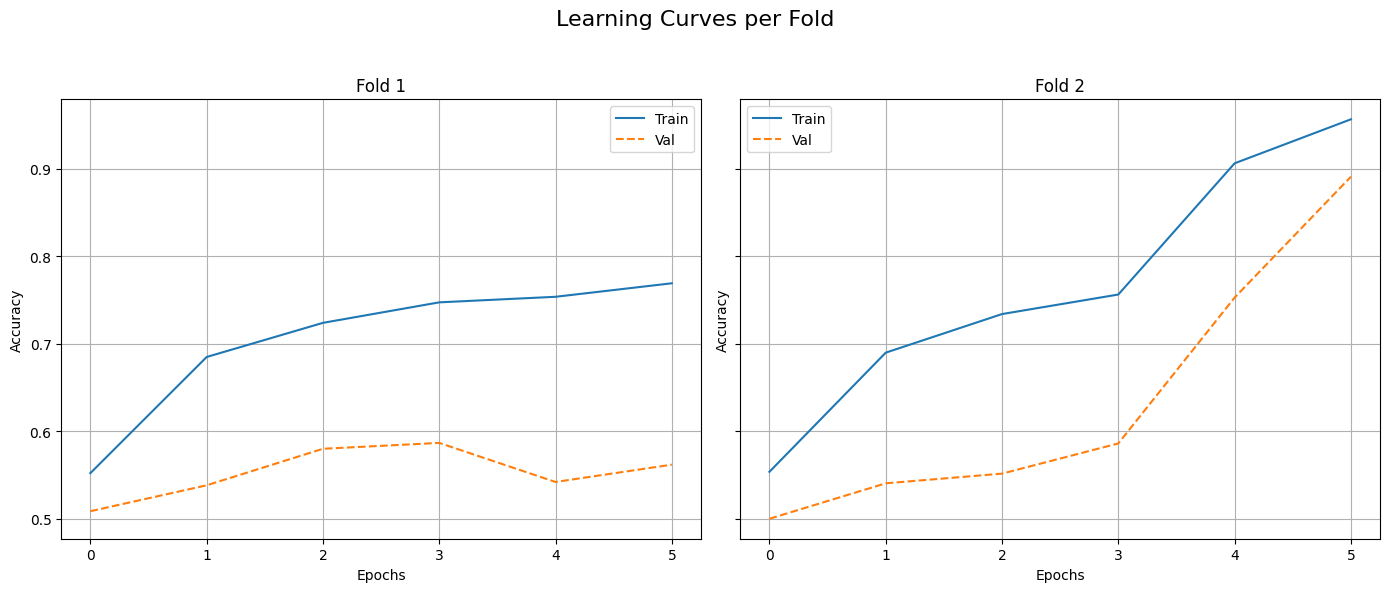

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i, history in enumerate(histories):
    ax = axes[i]
    ax.plot(history.history["accuracy"], label="Train")
    ax.plot(history.history["val_accuracy"], label="Val", linestyle="--")
    ax.set_title(f"Fold {i + 1}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.grid(True)
    ax.legend()

fig.suptitle("Learning Curves per Fold", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The learning curves look stable, showing a trend of improving accuracy with some mild acceptable overfitting, but more epochs would be needed to draw firmer conclusions or assess significant overfitting or underfitting.

We now prepare the full training set and train a final model using the best hyperparameters found during tuning.

In [ ]:
# Prepare final train set
X_text_train_input = prepare_text_input(X_text_train, tokenizer, best_hp.get("sequence_length"))

final_model = tuner.hypermodel.build(best_hp)
final_model.fit(
    x={"text_input": X_text_train_input, "features_input": X_features_train},
    y=y_train,
    epochs=best_hp.get("epochs"),
    batch_size=best_hp.get("batch_size"),
    verbose=1
)

Epoch 1/6
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5743 - loss: 1.4699
Epoch 2/6
345/345 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9144 - loss: 0.4500
Epoch 3/6
345/345 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9417 - loss: 0.2673
Epoch 4/6
345/345 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9572 - loss: 0.1834
Epoch 5/6
345/345 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9639 - loss: 0.1607
Epoch 6/6
345/345 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9626 - loss: 0.1506


We evaluate the final model on the test set, generate predictions, and visualize results with a confusion matrix and a classification report.

In [ ]:
# Prepare test data
X_text_test = prepare_text_input(X_text_test, tokenizer, best_hp.get("sequence_length"))
X_text_test = np.array(X_text_test, dtype=np.int32)
X_features_test = np.array(X_features_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Predict
y_test_pred_probs = final_model.predict({"text_input": X_text_test, "features_input": X_features_test})
y_test_pred = (y_test_pred_probs >= 0.5).astype(int)

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


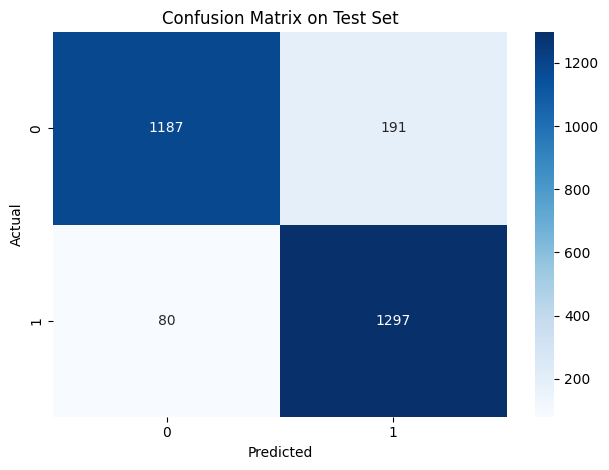

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

In [ ]:
print("Classification Report:\n")
print(classification_report(y_test, y_test_pred, digits=4))

Classification Report:

              precision    recall  f1-score   support

         0.0     0.9369    0.8614    0.8975      1378
         1.0     0.8716    0.9419    0.9054      1377

    accuracy                         0.9016      2755
   macro avg     0.9042    0.9016    0.9015      2755
weighted avg     0.9043    0.9016    0.9015      2755

